In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. Load and Prep Data
df = pd.read_csv('/content/waec_data.csv')

In [4]:
# Ensure numeric columns are actually numeric
cols = ['pass_eng_math', 'total_sat', 'pass_%']
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Recalculate pass_% to fill missing 2019-2021 data
df['pass_%'] = df['pass_%'].fillna((df['pass_eng_math'] / df['total_sat']) * 100)

# Set the visual style
sns.set_theme(style="whitegrid")

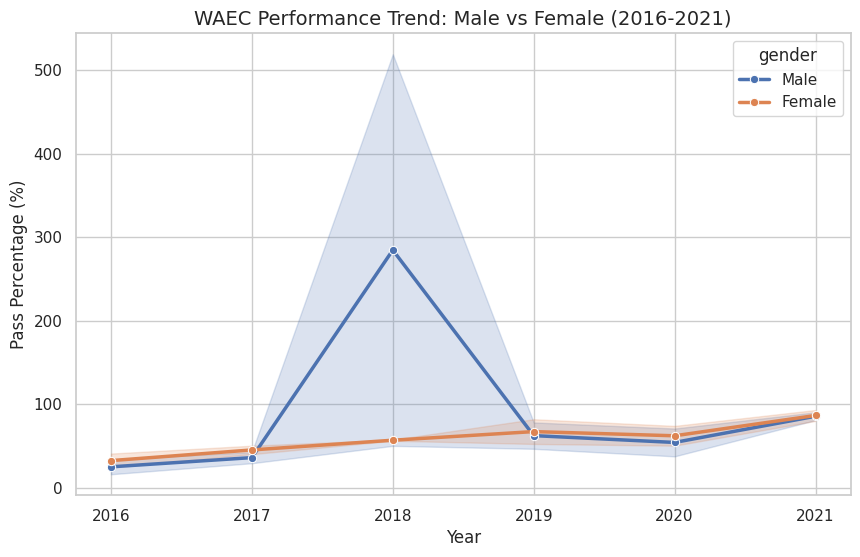

In [5]:
# --- CHART 1: Gender Performance Over Time ---
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='year', y='pass_%', hue='gender', marker='o', linewidth=2.5)
plt.title('WAEC Performance Trend: Male vs Female (2016-2021)', fontsize=14)
plt.ylabel('Pass Percentage (%)')
plt.xlabel('Year')
plt.show()

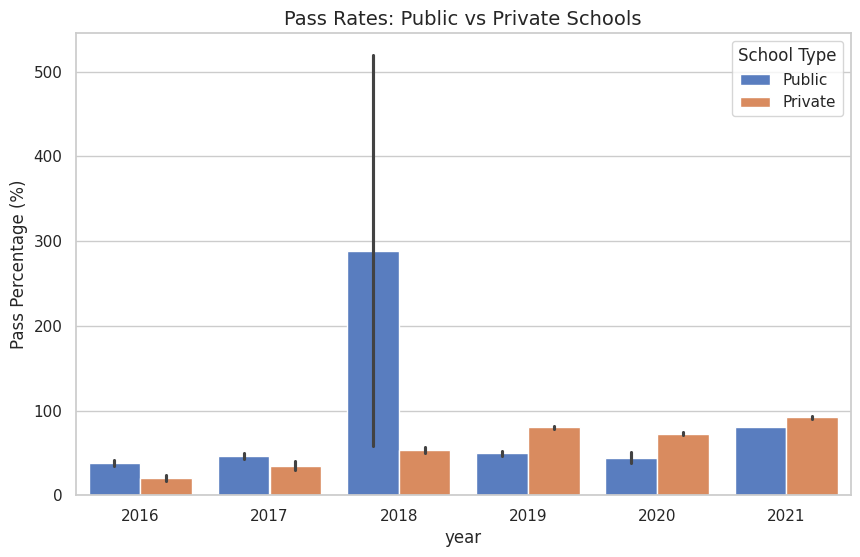

In [6]:
# --- CHART 2: Public vs Private School Efficiency ---
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='year', y='pass_%', hue='scholl_type', palette='muted')
plt.title('Pass Rates: Public vs Private Schools', fontsize=14)
plt.ylabel('Pass Percentage (%)')
plt.legend(title='School Type')
plt.show()

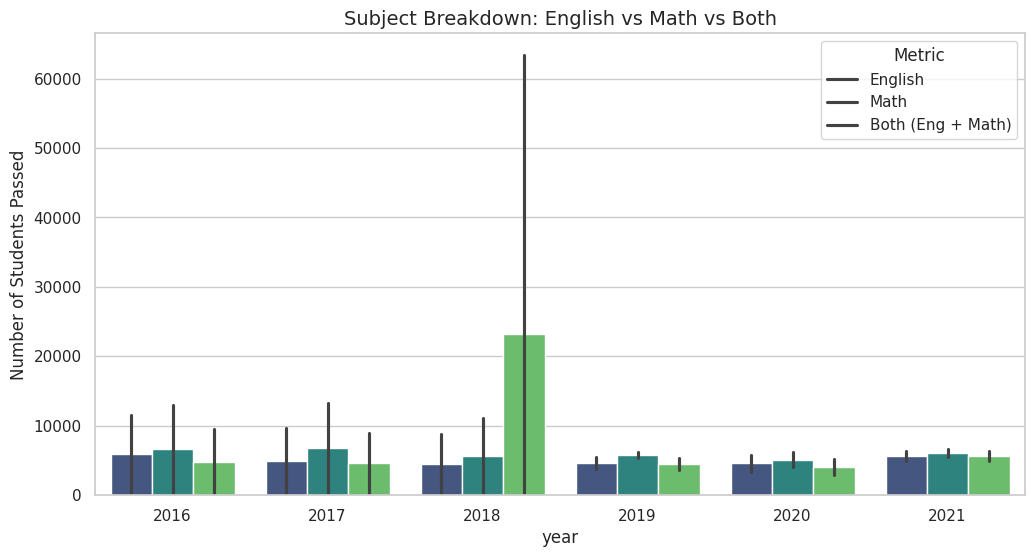

In [7]:
# --- CHART 3: The Subject "Bottleneck" (Math vs English) ---
# We need to "melt" the data to make it easy to plot side-by-side
melted_df = df.melt(id_vars=['year'], value_vars=['pass_eng', 'pass_math', 'pass_eng_math'],
                    var_name='Subject', value_name='Count')

plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='year', y='Count', hue='Subject', palette='viridis')
plt.title('Subject Breakdown: English vs Math vs Both', fontsize=14)
plt.ylabel('Number of Students Passed')
plt.legend(title='Metric', labels=['English', 'Math', 'Both (Eng + Math)'])
plt.show()

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error

In [10]:
# 1. Load Data
df = pd.read_csv('/content/waec_data.csv')

In [11]:
# 2. Cleaning: Ensure numeric types and fill missing pass_%
cols = ['pass_eng_math', 'total_sat', 'pass_%']
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Calculate missing pass_% (Essential for 2019-2021)
mask = df['pass_%'].isna()
df.loc[mask, 'pass_%'] = (df.loc[mask, 'pass_eng_math'] / df.loc[mask, 'total_sat']) * 100

# Drop bad rows (where total_sat is 0 or missing)
df = df.dropna(subset=['total_sat', 'pass_%'])

In [12]:
# 3. Feature Engineering (Converting Text to Numbers)
le_gender = LabelEncoder()
df['gender_encoded'] = le_gender.fit_transform(df['gender'].astype(str))

le_school = LabelEncoder()
df['scholl_type_encoded'] = le_school.fit_transform(df['scholl_type'].astype(str))

# Define Features and Target
# We use Year, Gender, School Type, and Total Sat to predict Pass %
features = ['year', 'gender_encoded', 'scholl_type_encoded', 'total_sat']
X = df[features]
y = df['pass_%']

In [19]:
# 4. Train the Model
# Splitting into 80% training data and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)

model = RandomForestRegressor(n_estimators=100, random_state=82)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=82)

In [37]:
# 5. Evaluate Model
accuracy = model.score(X_test, y_test)
print(f"Model Accuracy (R^2): {accuracy:.2f}")

# 6. Predict Future (e.g., 2022 for Public Schools)
# We assume 'total_sat' stays consistent with the 2021 average (approx 18,000 for public)
future_data = pd.DataFrame({
    'year': [2040, 2040],
    'gender_encoded': le_gender.transform(['Male', 'Female']),
    'scholl_type_encoded': le_school.transform(['Public', 'Public']),
    'total_sat': [18000, 18000] # Assumption based on 2021 data
})

Model Accuracy (R^2): -0.29


In [39]:
predictions = model.predict(future_data)
print(f"Predicted 2022 Pass Rate (Male): {predictions[0]:.2f}%")
print(f"Predicted 2022 Pass Rate (Female): {predictions[1]:.2f}%")

Predicted 2022 Pass Rate (Male): 74.15%
Predicted 2022 Pass Rate (Female): 76.11%


In [40]:
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder


# Numeric conversion
cols = ['pass_eng_math', 'total_sat', 'pass_%']
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing percentages
mask = df['pass_%'].isna()
df.loc[mask, 'pass_%'] = (df.loc[mask, 'pass_eng_math'] / df.loc[mask, 'total_sat']) * 100
df = df.dropna(subset=['total_sat', 'pass_%'])

# --- 2. Encode and Train ---
# Create Encoders
le_gender = LabelEncoder()
df['gender_encoded'] = le_gender.fit_transform(df['gender'].astype(str))

le_school = LabelEncoder()
df['scholl_type_encoded'] = le_school.fit_transform(df['scholl_type'].astype(str))

# Train
features = ['year', 'gender_encoded', 'scholl_type_encoded', 'total_sat']
X = df[features]
y = df['pass_%']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# --- 3. Save to Files ---
joblib.dump(model, 'waec_model.pkl')
joblib.dump(le_gender, 'gender_encoder.pkl')
joblib.dump(le_school, 'school_encoder.pkl')

print("Success! Model and encoders saved.")

Success! Model and encoders saved.


In [41]:
import joblib
import pandas as pd

# 1. Load the saved brains
model = joblib.load('/content/waec_model.pkl')
le_gender = joblib.load('/content/gender_encoder.pkl')
le_school = joblib.load('/content/school_encoder.pkl')

# 2. Define new data (Example: Predicting for 2025)
new_data = pd.DataFrame({
    'year': [2025],
    'gender': ['Female'],
    'scholl_type': ['Private'],
    'total_sat': [500]  # Example student volume
})

# 3. Translate text to numbers using the loaded encoders
new_data['gender_encoded'] = le_gender.transform(new_data['gender'])
new_data['scholl_type_encoded'] = le_school.transform(new_data['scholl_type'])

# 4. Predict
features = ['year', 'gender_encoded', 'scholl_type_encoded', 'total_sat']
prediction = model.predict(new_data[features])

print(f"Predicted Pass Rate: {prediction[0]:.2f}%")

Predicted Pass Rate: 81.02%


In [42]:
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

def update_model_with_feedback(new_data_dict, current_data_file='/content/waec_data.csv'):
    """
    1. Loads the existing historical data.
    2. Appends the new 'feedback' data.
    3. Retrains the model on the combined dataset.
    4. Saves the updated model and data.
    """

    # --- 1. Load Existing Database ---
    try:
        df = pd.read_csv(current_data_file)
    except FileNotFoundError:
        print("Error: Historical data file not found.")
        return

    # --- 2. Append New Feedback ---
    # Convert dictionary to DataFrame
    new_row = pd.DataFrame([new_data_dict])

    # Append to main dataframe
    df = pd.concat([df, new_row], ignore_index=True)

    # Save the updated dataset (so we don't lose this feedback!)
    df.to_csv(current_data_file, index=False)
    print(f"Database updated. Total records: {len(df)}")

    # --- 3. Data Cleaning (Same as before) ---
    cols = ['pass_eng_math', 'total_sat', 'pass_%']
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Recalculate pass_% if missing (or use the feedback's actual pass_%)
    mask = df['pass_%'].isna()
    if mask.any():
        df.loc[mask, 'pass_%'] = (df.loc[mask, 'pass_eng_math'] / df.loc[mask, 'total_sat']) * 100

    df = df.dropna(subset=['total_sat', 'pass_%'])

    # --- 4. Encode & Retrain ---
    # We must fit new encoders to handle any potentially new categories (though unlikely for Gender)
    le_gender = LabelEncoder()
    df['gender_encoded'] = le_gender.fit_transform(df['gender'].astype(str))

    le_school = LabelEncoder()
    df['scholl_type_encoded'] = le_school.fit_transform(df['scholl_type'].astype(str))

    features = ['year', 'gender_encoded', 'scholl_type_encoded', 'total_sat']
    X = df[features]
    y = df['pass_%']

    # Retrain
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    # --- 5. Save the Upgraded Model ---
    joblib.dump(model, 'waec_model.pkl')
    joblib.dump(le_gender, 'gender_encoder.pkl')
    joblib.dump(le_school, 'school_encoder.pkl')

    print("Model successfully retrained and saved with new feedback.")

# ==========================================
# EXAMPLE USAGE:
# Let's say the ACTUAL 2022 results come out and you want to feed them back.
# ==========================================

feedback_data = {
    'year': 2022,
    'state': 'Kano',
    'zone': 'North-West',
    'scholl_type': 'Public',
    'gender': 'Male',
    'total_sat': 19500,
    'pass_eng': 10000,       # Optional if you don't use it for training
    'pass_math': 11000,      # Optional
    'pass_eng_math': 8500,   # Crucial
    'pass_%': 43.59,         # The ACTUAL result (Feedback)
    'male_female_pass_%': 0  # Placeholder
}

# Run the update
# update_model_with_feedback(feedback_data)

In [43]:
update_model_with_feedback(feedback_data)

Database updated. Total records: 25
Model successfully retrained and saved with new feedback.
